In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load unsplash dataset**

In [ ]:
import numpy as np
import pandas as pd
import glob

path = 'drive/MyDrive/Datasets/unsplash-research-dataset-lite-latest/'
documents = ['photos', 'keywords', 'collections', 'conversions', 'colors']
datasets = {}

for doc in documents:
  files = glob.glob(path + doc + ".tsv*")

  subsets = []
  for filename in files:
    df = pd.read_csv(filename, sep='\t', header=0)
    subsets.append(df)

  datasets[doc] = pd.concat(subsets, axis=0, ignore_index=True)


In [ ]:
datasets['keywords'].head()

In [ ]:
datasets['conversions'].head()

**Spacy Loading Text Prompt**

In [ ]:
import spacy
from spacy import displacy
# load english language model

nlp = spacy.load('en_core_web_sm',disable=['ner','textcat'])

text = "4 chairs"

# create spacy 

doc = nlp(text)

for token in doc:
    print(token.text,'->',token.pos_)
    print(token.lemma_)

displacy.render(doc, style='dep',jupyter=True)

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['ner', 'textcat'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


4 -> NUM
4
chairs -> NOUN
chair


In [ ]:
for token in doc:
    # extract subject
    if (token.pos_=='NOUN'):
        num="1"
        for child in token.children:
          if child.dep_=='nummod':
            num=child.text
        print(num,token.text)

4 chairs


# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 4.5 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=cf737e5d8e556724e39865fc5955cdc4ac3b2dc133da3667b06cd60d41abd1e3
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14583, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

First loading image

In [ ]:
im = cv2.imread("/content/drive/MyDrive/Datasets/Dalle2/4 chairs on the ground.png")
#cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
print(outputs['instances'].pred_masks.size())

tensor([56, 56, 56, 56], device='cuda:0')
Boxes(tensor([[ 705.4233,  185.1753, 1024.0000,  648.5803],
        [ 596.2588,   82.0016,  891.2708,  556.3116],
        [ 260.4370,  102.0538,  521.3005,  507.0030],
        [   6.1824,  447.0967,  427.6335,  872.2834]], device='cuda:0'))
torch.Size([4, 1024, 1024])


In [ ]:
example_mask = outputs['instances'].pred_masks[0]
tmp = torch.nonzero(example_mask==True)
print(tmp.size())

torch.Size([125878, 2])


In [ ]:
classes = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes

#compute score

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['ner', 'textcat'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


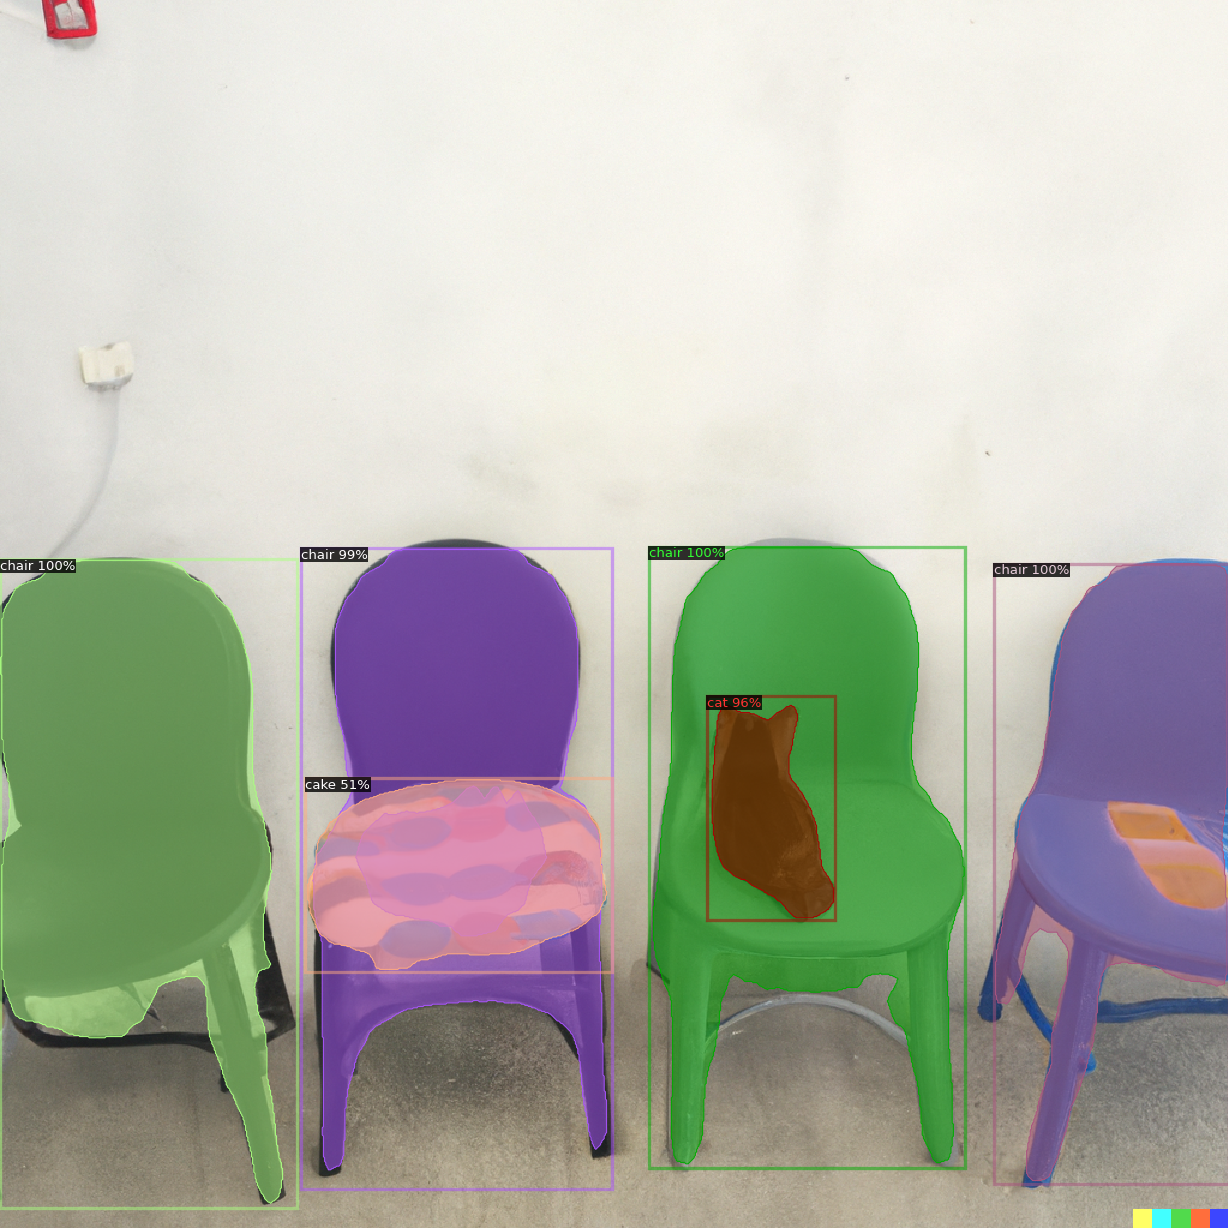

0.75

In [ ]:
import numpy as np

def score_objects_num(text, img, predictor):
  
  nlp = spacy.load('en_core_web_sm',disable=['ner','textcat'])
  doc = nlp(text)
  word_dict={}
  for token in doc:
    # extract subject
    if (token.pos_=='NOUN'):
        num=1
        for child in token.children:
          if child.dep_=='nummod':
            num=int(child.text)
        word_dict[token.lemma_]=num
  
  outputs = predictor(img)
  instance_dict={}
  for class_id in outputs["instances"].pred_classes:
    class_name = classes[int(class_id)]
    instance_dict[class_name]=instance_dict.get(class_name, 0)+1

  class_scores=[]
  for class_name in instance_dict.keys():
    if class_name in word_dict:
      class_scores.append(1-abs(instance_dict[class_name]-word_dict[class_name])/word_dict[class_name])
  # We can use `Visualizer` to draw the predictions on the image.
  v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

  #print(np.mean(class_scores))
  return np.mean(class_scores)

#score = score_objects_num(text,im,predictor)

text_1 = "4 chairs and 2 cats"

img_1 = cv2.imread("/content/drive/MyDrive/Datasets/Dalle2/DALL·E 2022-10-31 20.53.28 - 4 chairs and 2 cats.png")

score_objects_num(text_1,img_1,predictor)
